In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from datetime import datetime, timedelta

from sklearn.base import TransformerMixin
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

pd.options.display.max_columns = 99
pd.options.display.max_rows = 1000

In [124]:
def convertDatetime(x):
    x = str(x)
    date = x[:4] + '-' + x[4:6] + '-' + x[6:]
    return datetime.strptime(date, '%Y-%m-%d')

In [126]:
def getMonths(x):
    maturity = str(x['ActualMaturityDateKey'])
    issue = str(x['IssueDateKey'])
    try:
        yeardiff = int(maturity[:4]) - int(issue[:4])
        monthdiff = int(maturity[4:6]) - int(issue[4:6])
        return yeardiff*12 + monthdiff
    except:
        return None

In [2]:
data = pd.read_csv('./data/byweek_lag.csv')
volatile = pd.read_csv('./data/volatile.csv')

In [125]:
combined = data.merge(volatile,how='left',on='IsinIdx')

In [127]:
combined['ActualMaturityDateKey'] = combined['ActualMaturityDateKey'].apply(lambda x: convertDatetime(x))

In [128]:
combined['daysToMaturity'] = combined['ActualMaturityDateKey'] - combined['week'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [129]:
combined['daysToMaturity'] = combined['daysToMaturity'].apply(lambda x: int(x.days))

In [130]:
combined['IssueDateKey'] = combined['IssueDateKey'].apply(lambda x: convertDatetime(x))
combined['daysSinceIssue'] = combined['week'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d')) - combined['IssueDateKey']
combined['daysSinceIssue'] = combined['daysSinceIssue'].apply(lambda x: int(x.days)) 

In [132]:
combined.to_csv("combined.csv",index=False)

### Preprocessing - One hot encoding 

In [3]:
combined = pd.read_csv("combined.csv",index=False)

In [7]:
combined['lastday'] = combined['week'].apply(lambda x: int(x[-2:]))

In [8]:
combined = combined[combined['lastday']<24]

In [50]:
small = combined[combined['week']>='2017-06-01']

In [9]:
columns = ['week','CustomerIdx','IsinIdx','BuySell' ,'daysToMaturity','daysSinceIssue', 'Seniority', 'RiskCaptain'
           , 'CompositeRating', 'IndustrySector','MarketIssue', 'Sector', 'CouponType'
           ,'Country', 'Price', 'Yield', 'ZSpread', 'volrank', 'CustomerInterest']

In [10]:
features = ['BuySell' ,'daysToMaturity', 'Seniority','daysSinceIssue'
           , 'CompositeRating', 'IndustrySector','MarketIssue', 'Sector', 'CouponType',
           'Country', 'Price', 'Yield', 'ZSpread', 'volrank']

response = ['CustomerInterest']

In [11]:
df = combined[columns]

In [12]:
non_numeric_cols = ['BuySell', 'Seniority', 'CompositeRating', 'volrank','IndustrySector','MarketIssue', 'Sector', 'CouponType'
           ,'Country', 'volrank' ]

In [13]:
numeric_cols = ['daysToMaturity', 'daysSinceIssue', 'Price', 'Yield', 'ZSpread']

In [14]:
class DataFrameImputer(TransformerMixin):
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [15]:
dfImputer = DataFrameImputer()

In [16]:
X, y = df[features], df['CustomerInterest']

In [17]:
X = dfImputer.fit_transform(X)

In [18]:
scaler = RobustScaler(quantile_range=(25, 75))
for feature in numeric_cols:
    X[feature] = scaler.fit_transform(np.array(X[feature]).reshape(-1,1))

In [21]:
oe = OneHotEncoder()
for feature in non_numeric_cols:
    X[feature] = oe.fit_transform(X[feature])


### Modeling - Xgboost

In [41]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

In [38]:
X, y = X.as_matrix(), np.array(y)

/anaconda3/envs/kaggle/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


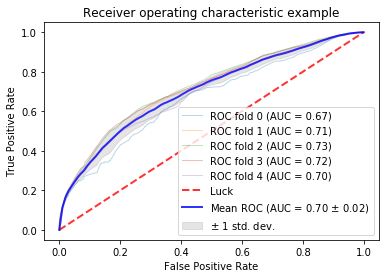

In [32]:
cv = StratifiedKFold(n_splits=5)
classifier = xgb.XGBClassifier(objective="binary:logistic", 
                              max_depth=6, n_round=100 ,eval_metric="auc", learning_rate=0.01)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
classifier.roc_auc_score(y_test['CustomerInterest'], classifier.predict_proba(X_test[features_noidx])[:,1])

In [39]:
y_test2 = [np.insert(i,0,1-i[0],axis=0) for i in y_test]

In [90]:
y_test

array([[ 1.],
       [ 0.],
       [ 1.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]])

In [96]:
y_test = np.array(y_test[['other','CustomerInterest']])

In [91]:
ypred[:,1]

array([ 0.33324394,  0.28377244,  0.42773935, ...,  0.16195369,
        0.32847562,  0.56858009], dtype=float32)

In [51]:
y_test = y_test.flatten()

In [52]:
y_test

array([ 1.,  0.,  1., ...,  0.,  0.,  0.])

In [53]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, ypred[:,1], pos_label=2)


In [54]:
fpr, tpr, thresholds

(array([ 0.        ,  0.21887574,  0.32698176,  1.        ]),
 array([ nan,  nan,  nan,  nan]),
 array([ 1.9966886 ,  0.99668854,  0.99668759,  0.00331077], dtype=float32))

In [37]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], ypred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


IndexError: index 1 is out of bounds for axis 1 with size 1

In [100]:
roc_auc

{0: 1.0, 1: 1.0}

In [1]:
from scipy import interp
import matplotlib.pyplot as plt
# Compute macro-average ROC curve and ROC area
n_classes=2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

NameError: name 'np' is not defined

## Submission

In [174]:
challenge = pd.read_csv('./data/Challenge_20180423.csv')
#challenge.sort_values('PredictionIdx',inplace=True)

In [175]:
customer = pd.read_csv('./data/Customer.csv')
isin = pd.read_csv('./data/Isin.csv')

In [176]:
one = challenge.merge(isin, on ='IsinIdx', how='left')
two = one.merge(customer, on='CustomerIdx', how='left')

In [177]:
two = two.merge(volatile,how='left',on='IsinIdx')

In [178]:
market = pd.read_csv('./data/Market.csv')
def convertDatetime(x):
    x = str(x)
    date = x[:4] + '-' + x[4:6] + '-' + x[6:]
    return datetime.strptime(date, '%Y-%m-%d')

In [179]:
market['date'] = market['DateKey'].apply(lambda x: convertDatetime(x))
market['week'] = market['date'].apply(lambda x: x - timedelta(days=x.weekday()))
marketbyweek = market.drop(['DateKey','date'], axis=1)
marketgrouped = marketbyweek.groupby(by=['week','IsinIdx'])['Price','Yield','ZSpread'].mean().reset_index()

In [180]:
marketgrouped['week'] = marketgrouped['week'].apply(lambda x: x + timedelta(days=7))

In [81]:
market_small = marketgrouped[marketgrouped['week'] >= '2018-04-16']
market_small['week'] = datetime.strptime('2018-04-23', '%Y-%m-%d')

/anaconda3/envs/kaggle/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [181]:
two['week'] = two['DateKey'].apply(lambda x: convertDatetime(x))

In [182]:
combined = two.merge(marketgrouped, how='left', on=['week','IsinIdx'])

In [183]:
combined['ActualMaturityDateKey'] = combined['ActualMaturityDateKey'].apply(lambda x: convertDatetime(x))
combined['week'] = combined['DateKey'].apply(lambda x: convertDatetime(x))
combined['daysToMaturity'] = combined['ActualMaturityDateKey'] - combined['week']
combined['daysToMaturity'] = combined['daysToMaturity'].apply(lambda x: int(x.days))

In [184]:
combined['IssueDateKey'] = combined['IssueDateKey'].apply(lambda x: convertDatetime(x))
combined['daysSinceIssue'] = combined['week'] - combined['IssueDateKey']
combined['daysSinceIssue'] = combined['daysSinceIssue'].apply(lambda x: int(x.days)) 

In [186]:
challenge_data = combined[columns]
challenge_X = challenge_data[features]
challenge_X = dfImputer.fit_transform(challenge_X)

In [189]:
for feature in non_numeric_cols:
    challenge_X[feature] = le.fit_transform(challenge_X[feature])

In [190]:
result = classifier.predict_proba(challenge_X.as_matrix())[:,1]

/anaconda3/envs/kaggle/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [192]:
submission = pd.read_csv('./data/sample_submission.csv')
submission.sort_values('PredictionIdx',inplace=True)
submission['CustomerInterest'] = result
submission.to_csv('0620_2.csv',index=False)